Let's put all the pieces together, and train a model:

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

First, we'll need training and test datasets. If you haven't already, run the cell below to make sure the dataset is downloaded. (It may take a minute.)

In [167]:
BATCH_SIZE = 16
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes_with_rejection = classes + ('UNKNOWN',)

Files already downloaded and verified
Files already downloaded and verified


We'll run our check on the output from `DataLoader`:

     truck       bird        car        cat        dog        dog        car      horse
       cat        car       ship       deer        cat      plane      truck        dog


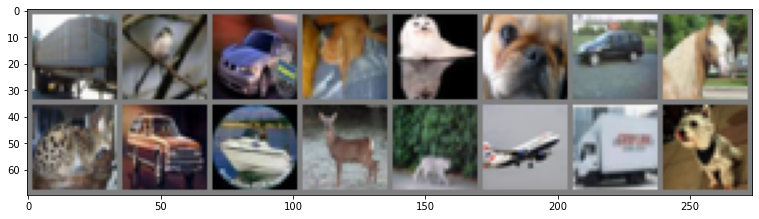

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (13,13))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [53]:
import sys 
sys.path.append('..')
use_cuda = torch.cuda.is_available()
print("use_cuda", use_cuda)

use_cuda True


In [54]:
model_path = "sat_cifar10.pth"
model = torch.load(model_path)
if use_cuda: model = model.cuda()

/home/tito/miniconda3/envs/condaPytorch/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/tito/miniconda3/envs/condaPytorch/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/tito/miniconda3/envs/condaPytorch/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has ch

In [55]:
class SelfAdativeTraining():
    def __init__(self, num_examples=50000, num_classes=10, mom=0.9):
        self.prob_history = torch.zeros(num_examples, num_classes)
        self.updated = torch.zeros(num_examples, dtype=torch.int)
        self.mom = mom
        self.num_classes = num_classes

    def _update_prob(self, prob, index, y):
        onehot = torch.zeros_like(prob)
        onehot[torch.arange(y.shape[0]), y] = 1
        prob_history = self.prob_history[index].clone().to(prob.device)

        # if not inited, use onehot label to initialize runnning vector
        cond = (self.updated[index] == 1).to(prob.device).unsqueeze(-1).expand_as(prob)
        prob_mom = torch.where(cond, prob_history, onehot)

        # momentum update
        prob_mom = self.mom * prob_mom + (1 - self.mom) * prob

        self.updated[index] = 1
        self.prob_history[index] = prob_mom.to(self.prob_history.device)

        return prob_mom

    def __call__(self, logits, y, index):
        prob = F.softmax(logits.detach()[:, :self.num_classes], dim=1)
        prob = self._update_prob(prob, index, y)

        soft_label = torch.zeros_like(logits)
        soft_label[torch.arange(y.shape[0]), y] = prob[torch.arange(y.shape[0]), y]
        soft_label[:, -1] = 1 - prob[torch.arange(y.shape[0]), y]
        soft_label = F.normalize(soft_label, dim=1, p=1)
        loss = torch.sum(-F.log_softmax(logits, dim=1) * soft_label, dim=1)
        return torch.mean(loss)

In [56]:
criterion = SelfAdativeTraining(num_examples=len(trainset), num_classes=len(classes), mom=.99)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9, weight_decay=5e-4)

In [57]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

True labels
     plane       bird       frog       frog       ship        car      plane       frog
      bird       bird       frog       deer        cat       deer        dog       ship
Predicted labels
   UNKNOWN       bird       frog       bird       ship        car      plane       frog
      bird    UNKNOWN       frog       deer        cat       deer        dog       ship


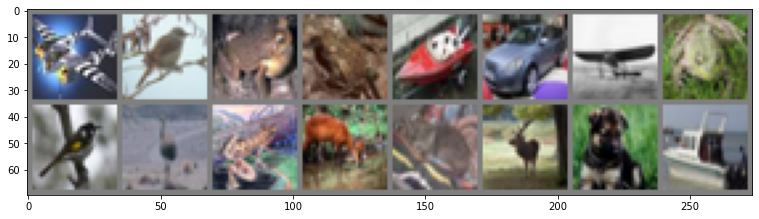

In [133]:
# get some random training images
found_doubt = False
dataiter = iter(testloader)
while found_doubt == False:
    images, labels = dataiter.next()
    initial_outputs = model(images).cpu()
    values, predictions = initial_outputs.data.max(1)
    outputs = F.softmax(initial_outputs, dim=1)
    reservation = outputs[:,-1]
    found_doubt = np.any(np.argmax(outputs.detach().numpy(), axis=1) == 10)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("True labels")
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))
print("Predicted labels")
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [135]:
print("Values", values)
print("predictions indices", np.where(predictions == 10))
print("predictions", values[predictions == 10])
print("Probs")
print(classes_with_rejection)
print(outputs[np.where(predictions == 10)].detach().numpy())

Values tensor([3.5728, 7.0143, 7.2816, 6.8199, 6.4335, 7.1028, 7.3123, 6.8934, 7.1961,
        4.1802, 6.7133, 7.2050, 6.8618, 7.1866, 6.9893, 7.0804])
predictions indices (array([0, 9]),)
predictions tensor([3.5728, 4.1802])
Probs
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'UNKNOWN')
[[0.184 0.001 0.074 0.128 0.002 0.005 0.082 0.002 0.002 0.001 0.518]
 [0.004 0.    0.293 0.006 0.317 0.002 0.001 0.001 0.002 0.    0.373]]


In [142]:
print("Misclassifications", np.where(predictions.eq(labels.data).numpy() == False))
print("Probs of misclassification")
print(classes_with_rejection)
print(outputs[np.where(predictions.eq(labels.data).numpy() == False)].detach().numpy())

Misclassifications (array([0, 3, 9]),)
Probs of misclassification
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'UNKNOWN')
[[0.184 0.001 0.074 0.128 0.002 0.005 0.082 0.002 0.002 0.001 0.518]
 [0.    0.    0.825 0.    0.    0.    0.004 0.    0.    0.    0.169]
 [0.004 0.    0.293 0.006 0.317 0.002 0.001 0.001 0.002 0.    0.373]]


In [144]:
print(reservation.detach().numpy() )

[0.518 0.154 0.086 0.169 0.151 0.08  0.096 0.15  0.086 0.373 0.163 0.085
 0.141 0.081 0.132 0.095]


In [148]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[k-1].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [173]:
abstention_results = []
top1 = AverageMeter()
top5 = AverageMeter()
generator = iter(testloader)
print("Total batches ", len(generator))
for batch_idx in range(len(generator)):
    batch_data = next(generator)
    inputs, labels = batch_data
    
    if use_cuda:
        inputs = inputs.cuda()
    inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

    with torch.no_grad():
        outputs = model(inputs).cpu()
        values, predictions = outputs.data.max(1)
        outputs = F.softmax(outputs, dim=1)
        outputs, reservation = outputs[:,:-1], outputs[:,-1]
        print("Batch: ", batch_idx)
        abstention_result = list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))
        print(abstention_result)
        abstention_results.extend(abstention_result)
        prec1, prec5 = accuracy(outputs.data, labels.data, topk=(1, 5))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))
    
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))

Total batches  625
Batch:  0
[(0.10044151, True), (0.075496286, True), (0.090331845, True), (0.16140522, True), (0.10045601, True), (0.119931415, True), (0.15911032, True), (0.30659306, False), (0.11222951, True), (0.0984573, True), (0.20893401, True), (0.08246461, True), (0.26864418, True), (0.080060974, True), (0.084007666, True), (0.2918505, True)]
Batch:  1
[(0.0852494, True), (0.16618955, True), (0.07212657, True), (0.095301956, True), (0.3143545, True), (0.33745676, True), (0.19906384, True), (0.08262107, True), (0.3102151, True), (0.19375448, True), (0.4283443, False), (0.1182682, True), (0.21262456, True), (0.09730041, True), (0.28657472, True), (0.122116715, True)]
Batch:  2
[(0.107824385, True), (0.2780774, True), (0.09037419, True), (0.2757634, False), (0.096878394, True), (0.16452672, True), (0.07861234, True), (0.0714058, True), (0.11304479, True), (0.13014877, True), (0.34357214, True), (0.12681367, True), (0.08504032, True), (0.081547074, True), (0.22381584, True), (0.51

Batch:  29
[(0.22183585, True), (0.08184565, True), (0.09526524, True), (0.094662994, True), (0.24594676, True), (0.07473078, True), (0.3055445, False), (0.08881379, True), (0.06959516, True), (0.31634882, False), (0.27071324, False), (0.08926503, True), (0.10156506, True), (0.32086965, True), (0.3448544, True), (0.078020856, True)]
Batch:  30
[(0.20154001, True), (0.08795711, True), (0.08262673, True), (0.37063614, False), (0.15119843, True), (0.117467776, False), (0.08449474, True), (0.08206382, True), (0.3257577, False), (0.15521128, True), (0.08590416, True), (0.3228415, False), (0.08670297, True), (0.06146745, True), (0.082510166, True), (0.08584233, True)]
Batch:  31
[(0.08652798, True), (0.104767896, True), (0.08860659, True), (0.17165014, True), (0.07982483, True), (0.49344915, False), (0.20066893, True), (0.09236733, True), (0.11677268, True), (0.08763533, True), (0.08510835, True), (0.09382057, True), (0.21403292, True), (0.074929364, True), (0.08084464, True), (0.13911217, T

Batch:  59
[(0.079755284, True), (0.10463741, True), (0.07429618, True), (0.08093177, True), (0.15588781, False), (0.081301294, True), (0.09468296, True), (0.0964564, True), (0.16517541, True), (0.2789048, False), (0.087713316, True), (0.096686766, True), (0.16441908, False), (0.15352215, True), (0.08302181, True), (0.08024597, True)]
Batch:  60
[(0.2747981, True), (0.121296935, True), (0.18540609, True), (0.102914184, True), (0.1410833, True), (0.14670296, True), (0.14475566, True), (0.16764106, True), (0.08191842, True), (0.08591326, True), (0.08324485, True), (0.08459794, True), (0.4617019, False), (0.11107611, True), (0.16062863, True), (0.06777749, True)]
Batch:  61
[(0.0934296, True), (0.0846416, True), (0.2663053, True), (0.09561099, True), (0.10240526, True), (0.35820663, False), (0.5110931, False), (0.08040015, True), (0.11074806, True), (0.07500448, True), (0.098616324, True), (0.076104514, True), (0.08952956, True), (0.23990615, True), (0.06996966, True), (0.46428266, False)

Batch:  89
[(0.09175662, True), (0.08137733, True), (0.08167472, True), (0.10714199, True), (0.10463297, True), (0.25756624, False), (0.09158665, True), (0.10580238, True), (0.08667711, True), (0.26949877, True), (0.07910797, True), (0.19418675, True), (0.1102213, True), (0.11185091, True), (0.3485543, True), (0.1267926, True)]
Batch:  90
[(0.2339854, True), (0.10093289, True), (0.40246478, False), (0.108503506, True), (0.13366613, True), (0.1325033, True), (0.11563531, True), (0.08021627, True), (0.0922096, True), (0.08059784, True), (0.18378934, True), (0.12190181, True), (0.07955994, True), (0.41685095, False), (0.23753132, True), (0.12289238, True)]
Batch:  91
[(0.21320419, False), (0.064063296, True), (0.07898464, True), (0.08204617, True), (0.10833774, True), (0.093422085, True), (0.10792008, True), (0.09918734, True), (0.10066735, True), (0.097849436, True), (0.08230005, True), (0.070982106, True), (0.097360134, True), (0.37933373, True), (0.21702781, False), (0.1431082, True)]


Batch:  117
[(0.08561299, True), (0.087669484, True), (0.094616994, True), (0.11595115, True), (0.12302243, True), (0.11844206, True), (0.08803904, True), (0.074016966, True), (0.07688747, True), (0.09162701, True), (0.07126871, True), (0.4011488, False), (0.39584073, False), (0.15798037, True), (0.20494224, False), (0.38251972, False)]
Batch:  118
[(0.09649415, True), (0.11521244, True), (0.36065707, True), (0.076719165, True), (0.1719861, True), (0.09066181, True), (0.09992016, True), (0.5006075, False), (0.21685383, False), (0.07846687, True), (0.37355876, False), (0.09452518, True), (0.07623592, True), (0.0858144, True), (0.12230173, True), (0.0809971, True)]
Batch:  119
[(0.065200604, True), (0.2313894, True), (0.41547984, False), (0.06428223, True), (0.52982414, False), (0.12856814, True), (0.16398874, True), (0.08142516, True), (0.09345667, True), (0.37212276, True), (0.12820409, True), (0.09544718, True), (0.08752784, True), (0.070513844, True), (0.08676365, True), (0.10342418,

Batch:  147
[(0.2602136, True), (0.0988243, True), (0.081380494, True), (0.26890635, False), (0.094418, True), (0.08821697, True), (0.19083141, True), (0.09139557, True), (0.11263111, True), (0.17608571, False), (0.33162823, False), (0.17842966, True), (0.093482755, True), (0.07731803, True), (0.10372718, True), (0.08963717, True)]
Batch:  148
[(0.09818461, True), (0.06598997, True), (0.070077695, True), (0.07557177, True), (0.11874883, False), (0.0672931, True), (0.11666921, True), (0.11367143, True), (0.08455009, True), (0.23298432, True), (0.19773646, True), (0.26524755, True), (0.07247647, True), (0.12115338, True), (0.08395265, True), (0.37278345, False)]
Batch:  149
[(0.083586775, True), (0.08731577, True), (0.27445537, False), (0.33737686, True), (0.104009375, True), (0.09980639, True), (0.3517046, False), (0.12751237, True), (0.12802875, True), (0.09133556, True), (0.31584042, True), (0.08619446, True), (0.0849739, True), (0.18122475, False), (0.08306164, True), (0.07639944, Tr

Batch:  177
[(0.16652192, True), (0.06543319, True), (0.10631669, True), (0.16980948, True), (0.11451828, True), (0.08314329, True), (0.089162596, True), (0.08563226, True), (0.37504557, True), (0.21537836, True), (0.092689075, True), (0.15678559, False), (0.23804142, False), (0.34106728, False), (0.08599989, True), (0.100909285, True)]
Batch:  178
[(0.09045923, True), (0.38332376, False), (0.08286864, True), (0.10176583, True), (0.1307802, True), (0.10153956, True), (0.42349857, False), (0.29195422, False), (0.09671882, True), (0.07807077, True), (0.08918292, True), (0.22459349, False), (0.111778975, True), (0.08667544, True), (0.09332286, True), (0.09400928, True)]
Batch:  179
[(0.08612204, True), (0.08891042, True), (0.10628634, True), (0.17974624, True), (0.36945617, False), (0.13124129, True), (0.0791574, True), (0.111964166, True), (0.08283381, True), (0.10677761, True), (0.25689298, True), (0.10874703, True), (0.118067965, True), (0.17386237, True), (0.14010817, True), (0.146980

[(0.07514779, True), (0.27010864, True), (0.35925615, True), (0.35027283, True), (0.08838573, True), (0.11890198, True), (0.09388723, True), (0.14992319, True), (0.088797316, True), (0.08070435, True), (0.15887162, False), (0.0826392, True), (0.17152949, True), (0.11228291, True), (0.08953096, True), (0.123961404, True)]
Batch:  207
[(0.48531345, False), (0.086063944, True), (0.14909439, True), (0.17175967, True), (0.07780118, True), (0.083565414, True), (0.07795642, True), (0.13479654, True), (0.35184562, False), (0.12337924, True), (0.10372591, True), (0.08275361, True), (0.13443494, True), (0.1236415, True), (0.07679415, True), (0.20172621, True)]
Batch:  208
[(0.09676676, True), (0.18091688, True), (0.1791388, True), (0.073512815, True), (0.1431605, True), (0.08657432, True), (0.24922016, True), (0.16427392, True), (0.4133522, True), (0.08105227, True), (0.082684234, True), (0.2867531, False), (0.105979785, True), (0.07325531, True), (0.2670137, False), (0.3366264, False)]
Batch:  

Batch:  233
[(0.30828834, False), (0.073721774, True), (0.09182018, True), (0.10871571, True), (0.11781303, True), (0.3168381, False), (0.12537356, True), (0.14537041, False), (0.15185297, True), (0.09038479, True), (0.08898485, True), (0.0782572, True), (0.08668118, True), (0.32802266, True), (0.09625277, True), (0.24098112, True)]
Batch:  234
[(0.10408165, True), (0.06144905, True), (0.104995154, True), (0.2365516, True), (0.10047568, True), (0.084542535, True), (0.091674894, True), (0.09293346, True), (0.18118164, True), (0.2984681, False), (0.22268869, True), (0.3478996, False), (0.073508106, True), (0.09076732, True), (0.12443196, True), (0.087650895, True)]
Batch:  235
[(0.09088564, True), (0.28423843, True), (0.24957538, True), (0.08579974, True), (0.08436767, True), (0.1971246, False), (0.082835935, True), (0.096337445, True), (0.165664, True), (0.10757803, True), (0.13788955, True), (0.12273674, True), (0.36426848, True), (0.09578583, True), (0.3789633, False), (0.084509, True

Batch:  263
[(0.18526652, True), (0.09684574, True), (0.35555685, True), (0.083791144, True), (0.08503713, True), (0.07915121, True), (0.34587586, True), (0.15384082, True), (0.132535, True), (0.24547337, True), (0.07919379, True), (0.10527952, True), (0.33067194, True), (0.092447914, True), (0.0870655, True), (0.09116992, True)]
Batch:  264
[(0.1352258, True), (0.19244477, True), (0.101469, True), (0.23316848, True), (0.107284136, True), (0.07365168, True), (0.110961914, True), (0.08875007, True), (0.081287876, True), (0.086509936, True), (0.08665857, True), (0.106577925, True), (0.06494652, True), (0.2773176, True), (0.289484, True), (0.09712355, True)]
Batch:  265
[(0.10442689, True), (0.1964528, True), (0.09545003, True), (0.11719182, True), (0.2791207, True), (0.1051139, True), (0.084970444, True), (0.13755211, True), (0.14824945, True), (0.08188053, True), (0.122692496, True), (0.27596352, True), (0.08528487, True), (0.11119372, True), (0.08519436, True), (0.19710903, False)]
Bat

Batch:  290
[(0.08499482, True), (0.18305169, True), (0.09045711, True), (0.25341263, True), (0.17790242, True), (0.08475776, True), (0.17094639, True), (0.107767254, True), (0.09194537, True), (0.07743411, True), (0.14400254, True), (0.08259391, True), (0.1635926, True), (0.10157345, True), (0.5236619, False), (0.2616761, True)]
Batch:  291
[(0.09768318, True), (0.08094915, True), (0.06349977, True), (0.13949908, True), (0.08560408, True), (0.26434475, True), (0.24470514, True), (0.0762758, True), (0.18559906, True), (0.16277547, True), (0.07858748, True), (0.0997328, True), (0.13479584, True), (0.30339295, True), (0.06588942, True), (0.08961953, True)]
Batch:  292
[(0.09404096, True), (0.3471939, False), (0.10713986, True), (0.07590749, True), (0.24365965, True), (0.07837052, True), (0.25001845, False), (0.13106245, True), (0.089316644, True), (0.11388572, True), (0.4512473, False), (0.07996842, True), (0.07208742, True), (0.084532164, True), (0.10424614, False), (0.11686217, True)]


Batch:  320
[(0.14308885, True), (0.08514753, True), (0.092551544, True), (0.13466273, True), (0.06578521, True), (0.10003581, True), (0.13874009, True), (0.09483154, True), (0.116507284, True), (0.3512687, True), (0.46934074, False), (0.10474764, True), (0.09010953, True), (0.09157821, True), (0.44109538, False), (0.07128946, True)]
Batch:  321
[(0.08224673, True), (0.084873796, True), (0.08818695, True), (0.13984843, True), (0.07532422, True), (0.31653774, False), (0.09034217, True), (0.08013651, True), (0.1194248, True), (0.08511733, True), (0.24332346, False), (0.10229538, True), (0.2695266, True), (0.08886396, True), (0.10016942, True), (0.18454531, False)]
Batch:  322
[(0.46503812, False), (0.08874131, True), (0.33656326, True), (0.14158389, True), (0.13286287, True), (0.086473726, True), (0.14241473, True), (0.16371639, True), (0.07052331, True), (0.09675642, True), (0.26713696, False), (0.30994558, True), (0.11743776, True), (0.27113843, True), (0.41073266, False), (0.09102988,

Batch:  350
[(0.4327189, True), (0.08258059, True), (0.07870374, True), (0.3678794, True), (0.07399078, True), (0.14414583, True), (0.08229625, True), (0.3621782, True), (0.0842481, True), (0.1716243, False), (0.3568052, True), (0.22553752, True), (0.08575413, True), (0.17106307, True), (0.07300711, True), (0.14657418, True)]
Batch:  351
[(0.09727126, True), (0.3467767, True), (0.12270038, True), (0.07520845, True), (0.18891983, False), (0.11096417, True), (0.4481889, False), (0.07915232, True), (0.07340109, True), (0.25202128, True), (0.20324679, True), (0.09935321, True), (0.3614465, True), (0.116190396, True), (0.19393462, True), (0.35169604, False)]
Batch:  352
[(0.32635605, False), (0.08080663, True), (0.22756743, True), (0.2777592, True), (0.111567594, True), (0.18958122, True), (0.14977926, True), (0.120418616, True), (0.31017464, False), (0.07656204, True), (0.1040104, False), (0.13896243, True), (0.10893076, True), (0.3464128, True), (0.10096839, True), (0.38199875, True)]
Bat

Batch:  380
[(0.08552515, True), (0.11747648, True), (0.089990206, True), (0.1342392, False), (0.08242377, True), (0.14920908, True), (0.064797945, True), (0.07755566, True), (0.11141423, True), (0.096170746, True), (0.074853174, True), (0.11986926, True), (0.08833708, True), (0.10470445, True), (0.19627082, True), (0.124098845, True)]
Batch:  381
[(0.091902226, True), (0.09101946, True), (0.10094115, True), (0.093899466, True), (0.07976353, True), (0.16187814, True), (0.19903421, True), (0.08682903, True), (0.07030404, True), (0.13377409, True), (0.08395083, True), (0.08063112, True), (0.07603484, True), (0.17299688, True), (0.087855965, True), (0.16634881, True)]
Batch:  382
[(0.12944002, True), (0.08771589, True), (0.08341188, True), (0.07305826, True), (0.33627394, False), (0.076659776, True), (0.12223292, True), (0.064258926, True), (0.075679556, True), (0.09519531, True), (0.117129, False), (0.09071128, True), (0.083894186, True), (0.17933367, True), (0.10272486, True), (0.508833

Batch:  410
[(0.3691291, False), (0.09910905, True), (0.40380555, True), (0.08994494, True), (0.12449161, True), (0.112018034, True), (0.073872395, True), (0.077877045, True), (0.28372645, True), (0.12869318, True), (0.22457717, True), (0.08859315, True), (0.08890942, True), (0.08318239, True), (0.30261052, False), (0.1038249, True)]
Batch:  411
[(0.07917381, True), (0.09034136, True), (0.10287075, True), (0.114678696, True), (0.52278405, False), (0.104341894, True), (0.075906456, True), (0.07727808, True), (0.28516397, True), (0.079596125, True), (0.11135449, True), (0.11778175, True), (0.400981, False), (0.08901521, True), (0.46283263, False), (0.16941299, True)]
Batch:  412
[(0.07095515, True), (0.28255245, True), (0.37381727, False), (0.09296094, True), (0.35447228, False), (0.060446385, True), (0.12597753, True), (0.12308818, True), (0.080701165, True), (0.101845756, True), (0.07343185, True), (0.09894313, True), (0.09767405, True), (0.19961932, True), (0.14278443, True), (0.10779

Batch:  440
[(0.31120232, False), (0.32637417, True), (0.08716778, True), (0.086832784, True), (0.13939498, True), (0.09764275, True), (0.4955122, False), (0.07061903, True), (0.21236862, True), (0.085090734, True), (0.10838531, True), (0.098573364, True), (0.065198, True), (0.07113062, True), (0.109798014, True), (0.15915774, True)]
Batch:  441
[(0.1402052, True), (0.09235264, True), (0.08664265, True), (0.32706517, False), (0.072027534, True), (0.52526313, False), (0.1921419, True), (0.09884806, True), (0.078481704, True), (0.32344928, True), (0.08597357, True), (0.10188088, True), (0.24245356, False), (0.08409833, True), (0.11293137, True), (0.073126905, True)]
Batch:  442
[(0.08184922, True), (0.09171422, True), (0.30492878, True), (0.094961524, True), (0.103817426, True), (0.2785214, True), (0.13462919, True), (0.079313755, True), (0.42470002, False), (0.15184924, True), (0.13265468, True), (0.098157085, True), (0.07379615, True), (0.08414685, True), (0.08542363, True), (0.2501933

Batch:  470
[(0.3392981, False), (0.086059205, True), (0.08854774, True), (0.085915774, True), (0.529955, False), (0.07076845, True), (0.33067933, True), (0.14613836, True), (0.072612785, True), (0.08880978, True), (0.26945132, True), (0.08284381, True), (0.07767055, True), (0.08294602, True), (0.09369773, True), (0.072196074, True)]
Batch:  471
[(0.10246093, True), (0.08428374, True), (0.08951346, True), (0.455774, False), (0.0772582, True), (0.12366212, True), (0.12946734, True), (0.25390893, False), (0.19511898, True), (0.46803996, False), (0.090185314, True), (0.076914966, True), (0.11217388, True), (0.22749141, True), (0.075054444, True), (0.10735868, True)]
Batch:  472
[(0.081295475, True), (0.09493381, True), (0.19403987, True), (0.07305015, True), (0.10335723, True), (0.33503202, True), (0.10170604, True), (0.2807044, True), (0.074230224, True), (0.2325956, False), (0.21506783, True), (0.08371659, True), (0.082908325, True), (0.0810911, True), (0.08415515, True), (0.09206247, T

Batch:  499
[(0.07584013, True), (0.14169155, True), (0.080877855, True), (0.066511445, True), (0.14943728, True), (0.32866132, True), (0.1578195, True), (0.07819813, True), (0.088602, True), (0.1864263, True), (0.1481874, True), (0.08400342, True), (0.10170543, True), (0.072834745, True), (0.087451555, True), (0.15141775, False)]
Batch:  500
[(0.17001022, True), (0.22222927, True), (0.1271817, True), (0.1312796, True), (0.09044602, True), (0.07844989, True), (0.21857834, False), (0.09130878, True), (0.07574091, True), (0.48070455, False), (0.09464205, True), (0.20148951, True), (0.10401946, True), (0.08424214, True), (0.12918463, False), (0.078013256, True)]
Batch:  501
[(0.1648997, True), (0.0883015, True), (0.07840553, True), (0.12247548, True), (0.34462762, True), (0.07046845, True), (0.17314091, True), (0.13136701, True), (0.09718292, True), (0.22229964, True), (0.07430204, True), (0.08547665, True), (0.08036891, True), (0.084064916, True), (0.12013943, True), (0.25586846, True)]


Batch:  527
[(0.40336406, True), (0.1272805, True), (0.09974352, True), (0.10538968, True), (0.26255322, True), (0.091622815, True), (0.07113016, True), (0.089801624, True), (0.17150587, True), (0.07603321, True), (0.09464805, True), (0.21341322, True), (0.3475366, True), (0.06785604, True), (0.5829852, False), (0.11488682, True)]
Batch:  528
[(0.42282888, True), (0.1910178, False), (0.5397327, False), (0.21137847, False), (0.08589696, True), (0.08277319, True), (0.099676244, True), (0.063544974, True), (0.1310186, True), (0.4799127, False), (0.077526376, True), (0.087600745, True), (0.07101967, True), (0.13552326, True), (0.14375414, True), (0.49779373, False)]
Batch:  529
[(0.09653939, True), (0.1498945, True), (0.1668041, True), (0.102451675, True), (0.48185927, False), (0.13842033, False), (0.08196874, True), (0.1660257, False), (0.083550006, True), (0.20920783, True), (0.08655689, True), (0.24903555, True), (0.39306104, True), (0.08483288, True), (0.18806556, True), (0.091158636, 

Batch:  557
[(0.07600835, True), (0.065205105, True), (0.07693305, True), (0.08952501, True), (0.13533463, True), (0.0739586, True), (0.13518912, True), (0.2562162, True), (0.11377312, True), (0.11450095, True), (0.11860193, True), (0.12962256, True), (0.094612256, True), (0.15719561, True), (0.08089198, True), (0.08652111, True)]
Batch:  558
[(0.08805616, True), (0.08845914, True), (0.33858377, True), (0.10480777, True), (0.3200088, False), (0.21044192, True), (0.09863284, True), (0.08184774, True), (0.23354603, True), (0.15443537, True), (0.26895043, False), (0.15856168, True), (0.15250811, True), (0.3264859, False), (0.14342593, True), (0.21111502, False)]
Batch:  559
[(0.0986273, True), (0.070241824, True), (0.12744193, True), (0.12039326, True), (0.15137798, True), (0.12716061, True), (0.10014114, True), (0.0760339, True), (0.13011141, True), (0.07766748, True), (0.098062634, True), (0.15671018, True), (0.18777098, True), (0.13124493, True), (0.40571216, False), (0.09042407, True)

Batch:  586
[(0.22950849, False), (0.1021653, True), (0.1395385, True), (0.08298102, True), (0.18684885, False), (0.09103832, True), (0.08844423, True), (0.11867187, True), (0.08442031, True), (0.47620073, False), (0.2396771, False), (0.07940082, True), (0.09605694, True), (0.17739065, True), (0.10414213, True), (0.087792695, True)]
Batch:  587
[(0.13836867, True), (0.1010659, True), (0.092969306, True), (0.088177755, True), (0.09715253, True), (0.099336185, True), (0.11153048, True), (0.08173322, True), (0.15398833, True), (0.08758743, True), (0.27707362, False), (0.09247574, True), (0.19203517, True), (0.07339224, True), (0.07869764, True), (0.08139498, True)]
Batch:  588
[(0.08509119, True), (0.09159815, True), (0.081977084, True), (0.122447506, True), (0.064701706, True), (0.080394015, True), (0.39493057, False), (0.22056882, True), (0.11931983, True), (0.23100293, True), (0.10217424, True), (0.09719562, True), (0.086580835, True), (0.21392575, True), (0.2580632, True), (0.21343458

Batch:  616
[(0.07341197, True), (0.27346742, False), (0.12212876, True), (0.091897324, True), (0.07657294, True), (0.09369863, True), (0.30635104, True), (0.08905195, True), (0.084565446, True), (0.07887031, True), (0.2898584, False), (0.13288027, True), (0.12816562, True), (0.2691296, True), (0.09389128, True), (0.0938437, True)]
Batch:  617
[(0.23198637, False), (0.10520903, True), (0.08667648, True), (0.13542326, True), (0.08645088, True), (0.25594684, True), (0.2347546, True), (0.3718568, False), (0.17153773, False), (0.12844016, True), (0.08157453, True), (0.11540066, True), (0.15390044, True), (0.12754488, True), (0.105085336, True), (0.09583774, True)]
Batch:  618
[(0.15920675, True), (0.09650571, True), (0.06684983, True), (0.13814299, True), (0.29912043, False), (0.100855395, True), (0.36072505, True), (0.088113606, True), (0.081412494, True), (0.073639825, True), (0.23061676, True), (0.08165453, True), (0.07324371, True), (0.43054006, False), (0.11997299, True), (0.09889071,

In [174]:
list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))

[(0.13624763, True),
 (0.46508667, False),
 (0.08878148, True),
 (0.18905057, True),
 (0.08014711, True),
 (0.09991484, False),
 (0.12165369, True),
 (0.09028902, True),
 (0.10870177, True),
 (0.15061264, True),
 (0.100562036, True),
 (0.4594861, False),
 (0.29007557, True),
 (0.09489808, True),
 (0.08596452, True),
 (0.09132371, True)]

In [185]:
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))
size = len(testloader)*BATCH_SIZE
size

10000

In [182]:
print(abstention_results)

[(0.6359513, False), (0.6182231, False), (0.6129226, False), (0.60801005, False), (0.59339523, False), (0.5916331, False), (0.5871306, False), (0.58449686, False), (0.5829852, False), (0.58038473, False), (0.579558, False), (0.5739991, False), (0.5717814, False), (0.56943613, False), (0.5678899, False), (0.56684357, False), (0.5665441, False), (0.5663571, False), (0.5618225, False), (0.558615, False), (0.5583438, False), (0.5579154, False), (0.55507064, False), (0.5549631, False), (0.554837, False), (0.5531747, False), (0.5495509, False), (0.5489463, False), (0.5470911, False), (0.5456396, False), (0.5449566, False), (0.54470104, False), (0.5443038, False), (0.5438246, False), (0.5423794, False), (0.5422045, False), (0.54188466, False), (0.54123515, False), (0.54120153, False), (0.54006433, False), (0.5397327, False), (0.5376559, False), (0.5370923, False), (0.53628874, False), (0.536067, False), (0.5357584, False), (0.53565437, False), (0.5356379, False), (0.5353028, False), (0.534999

In [215]:
coverage = 50.
print(int(size*coverage/100))
len(sorted_correct[int(size*(1-coverage/100)):])

5000


5000

In [177]:
sorted_correct

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [218]:
expected_coverage = [100.,99.,98.,97.,95.,90.,85.,80.,75.,70.,60.,50.,40.,30.,20.,10.]
for coverage in expected_coverage:
    #print("coverage", coverage)
    #print("size", size)
    #print("sorted_correct:", sorted_correct)
    #print("abstention_results" ,abstention_results)
    print('{:.0f}: {:.3f}, '.format(coverage, sum(sorted_correct[int(size*(1-coverage/100)):]), end=''))

100: 8623.000, 
99: 8623.000, 
98: 8623.000, 
97: 8623.000, 
95: 8569.000, 
90: 8328.000, 
85: 8044.000, 
80: 7700.000, 
75: 7300.000, 
70: 6875.000, 
60: 5949.000, 
50: 4979.000, 
40: 3992.000, 
30: 2993.000, 
20: 1998.000, 
10: 1000.000, 


In [219]:
model.eval()

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.3, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout2d(p=0.4, inplace=False)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [227]:
accuracy(outputs[:,:-1].data, labels.data, topk=(1, 5))

[tensor(81.2500), tensor(6.2500)]

In [231]:
def bisection_method(abortion, correct, results):
    upper = 1.
    while True:
        mask_up = abortion <=  upper
        passed_up = torch.sum(mask_up.long()).item()
        if passed_up/len(correct)*100.<expected_coverage[0]: upper *= 2.
        else: break
    test_thres = 1.
    for coverage in expected_coverage:
        mask = abortion <=  test_thres
        passed = torch.sum(mask.long()).item()
        # bisection method start
        lower = 0.
        while math.fabs(passed/len(correct)*100.-coverage) > 0.3:
            if passed/len(correct)*100.>coverage:
                upper = min(test_thres,upper)
                test_thres=(test_thres+lower)/2
            elif passed/len(correct)*100. < coverage:
                lower = max(test_thres,lower)
                test_thres=(test_thres+upper)/2
            mask = abortion <=  test_thres
            passed = torch.sum(mask.long()).item()
            # bisection method end
        masked_correct = correct[mask]
        correct_data = torch.sum(masked_correct.long()).item()
        passed_acc = correct_data/passed
        results.append((passed/len(correct), passed_acc))
        # print('coverage {:.0f} done'.format(coverage))


In [233]:
import random
import math

abortionresults = [[],[]]
with torch.no_grad():
    for batch_idx, batch_data in enumerate(testloader):
        inputs, targets = batch_data[:2]
        if use_cuda:
            inputs, targets = inputs.cuda(), targets
        output = model(inputs)
        output = @to
        output, reservation = output[:,:-1], (output[:,-1]).cpu()
        values, predictions = output.data.max(1)
        predictions = predictions.cpu()
        abortion_results[0].extend(list( reservation ))
        abortion_results[1].extend(list( predictions.eq(targets.data) ))
def shuffle_list(lst, seed=10):
    random.seed(seed)
    random.shuffle(lst)
shuffle_list(abortion_results[0]); shuffle_list(abortion_results[1])
abortion, correct = torch.stack(abortion_results[0]), torch.stack(abortion_results[1])
# use 2000 data points as the validation set (randomly shuffled)
abortion_valid, abortion = abortion[:2000], abortion[2000:]
correct_valid, correct = correct[:2000], correct[2000:]
results_valid = []; results = []
bisection_method(abortion_valid, correct_valid, results_valid)
bisection_method(abortion, correct, results)
print("Vali\tCoverage\tError")
for idx, _ in enumerate(results_valid):
    print('{:.0f},\t{:.2f},\t\t{:.3f}'.format(expected_coverage[idx], results_valid[idx][0]*100., (1 - results_valid[idx][1])*100))
print("\nTest\tCoverage\tError")
for idx, _ in enumerate(results):
    print('{:.0f},\t{:.2f},\t\t{:.3f}'.format(expected_coverage[idx], results[idx][0]*100., (1 - results[idx][1])*100))

Vali	Coverage	Error
100,	100.00,		12.000
99,	98.75,		11.392
98,	97.95,		10.924
97,	97.15,		10.499
95,	94.90,		9.273
90,	90.20,		7.428
85,	85.20,		5.810
80,	80.00,		4.063
75,	74.95,		3.002
70,	70.10,		2.140
60,	60.15,		0.748
50,	49.80,		0.201
40,	40.15,		0.125
30,	29.80,		0.168
20,	19.90,		0.000
10,	10.30,		0.000

Test	Coverage	Error
100,	100.00,		11.979
99,	98.83,		11.223
98,	97.97,		10.750
97,	96.88,		10.246
95,	95.02,		9.430
90,	90.15,		7.505
85,	85.08,		5.410
80,	79.89,		3.739
75,	75.08,		2.657
70,	69.83,		1.718
60,	60.13,		0.853
50,	49.84,		0.412
40,	39.92,		0.204
30,	29.81,		0.238
20,	19.78,		0.106
10,	10.20,		0.000
